# Simulation confound strategies
This notebook evaluates the effectiveness of "confound strategies", i.e. their effectiveness of removing the influence of a known confound on machine learning analyses of (simulations of) mutivoxel pattern data. This notebook is meant as a supplement to the [article](link). Together with the notebook with [empirical analyses](empirical_analysis_gender_classification.ipynb), it hopefully complements the article and clarifies our methods and results.

## Contents
- Part A: Generic simulation
- Part B: Counterbalancing follow-up simulation
- Part C: WDCR/FwCR follow-up simulation

In [1]:
# General packages
import numpy as np
import seaborn as sns
import pandas as pd

# Bunch of scikit-learn stuff
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.externals import joblib as jl
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

# Specific statistics-functions
from scipy.stats import pearsonr

# Misc.
import tqdm
tqdm.monitor_interval = 0
from tqdm import tqdm_notebook

from copy import deepcopy
from matplotlib_venn import venn3

# Plotting
import matplotlib.pyplot as plt
sns.set_style("ticks")
%matplotlib inline

# Custom code! (install skbold by `pip install skbold`; counterbalance.py is in cwd)
from skbold.preproc import ConfoundRegressor
from counterbalance import CounterbalancedStratifiedSplit

/home/lukas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## PART A: generic simulation
In this notebook's simulations, we are going to simulate three variables, with $N$ denoting the number of samples, and $K$ denoting the number of features:

- **y**: an $N\times 1$ vector with values {0, 1}
- **c**: an $N\times 1$ vector with values {0, 1} if continuous, else $c \sim \mathcal{N}(0,\,1)$
- **X**: an $N\times K$ matrix, in each each column $j$ is generated as $X_{j} = \beta_{1} c + \beta_{2} y + \epsilon,\ \epsilon \sim \mathcal{N}(0, 1)$

By tweaking the parameters $\beta c$ and $\beta y$, we can specifically "tune" how much variance of $y$ is explained by the "true" (i.e., unconfounded) signal (which we call $signal\ R^2$) and how much variance of $y$ is explained by the "confounded signal" (i.e., signal in $X$ which is confounded by $c$; we call this $confound\ R^2$). 

Basically, in our data-generator (function is defined below) we generate data ($X$, $y$, and $c$) with a specified correlation between $y$ and $c$, $\rho(cy)$, and subsequently calculate the $confound\ R^2$ and $signal\ R^2$ terms. We then check whether these terms correspond to the desired values for these terms; if not, we adjust the generative parameters ($\beta_{1}$ and $\beta_{2}$) slightly and try the entire process again until we get the terms that we want.

Below, we visualized the $confound\ R^2$ and $signal\ R^2$ terms in a Venn-diagram. On the right of the diagram, we describe the steps to get these terms.

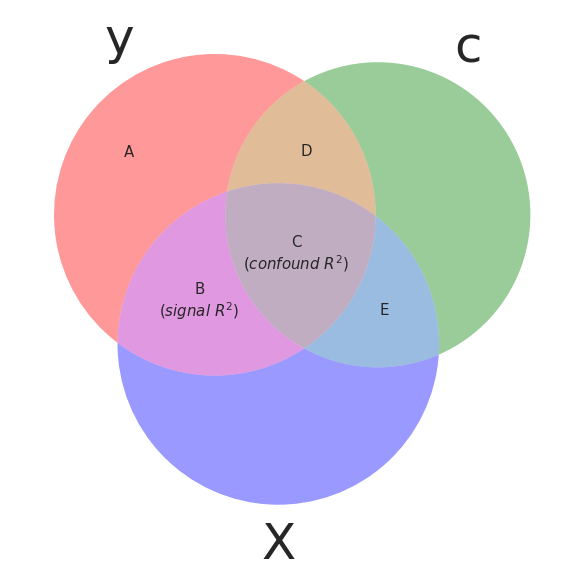

In [2]:
mappings = {'100': 'A', '110': 'D', '010': '',
            '101': "B\n($signal\ R^2$)", '111': 'C\n($confound\ R^2$)', '011': 'E',
            '001': ''}

plt.figure(figsize=(10, 10))
v = venn3(subsets=(1, 1, 0.1, 1, 0.3, 0.1, 0.6), set_labels=('y', 'c', 'X'))

for key, value in mappings.items():
    v.get_label_by_id(key).set_text(value)
    v.get_label_by_id(key).set_size(15)
    
for label in ['A', 'B', 'C']:
    v.get_label_by_id(label).set_size(50)

plt.show()

## Define some functions
Below, we define our main data-generation class - `DataGenerator` - which generates three variables - $X$, $y$, $c$ - corresponding to our predictors, target, and confound, respectively. (But when setting `c=None`, you can also only simulate $X$ and $y$ *without* $c$.)

In [3]:
from utils import get_r2
import time

class DataGenerator:
    
    def __init__(self, N, K, corr_cy, signal_r2, confound_r2=None,
                 c_type='continuous', y_type='binary', tolerance=0.01,
                 verbose=False):
        """
        Parameters
        ----------
        N : int
            Number of samples (N) in the data (X, y, and c)
        K : int
            Number of features (K) in the data (X)
        c_type : str
            Type of confound; either "continuous" or "binary". If binary,
            the data a balanced vector with ones and zeros
        y_type : str
            Type of target; either "continuous" or "binary".
        corr_cy : float
            Number between -1 and 1, specifying the correlation
            between the confound (c) and the target (y)
        signal_r2 : float
            Number between 0 and 1, specifying the explained variance
            of y using X, independent of the confound contained in X;
            (technically, the semipartial correlation rho(xy.c)
        confound_r2 : float or None
            Number between 0 and 1 (or None), specifying the shared variance 
            explained of y of x and c (i.e. the explained variance 
            of the confound-related information in x). If None,
            no confound R2 will be left unspecified (which can be used
            to specify a baseline).
        tolerance : float
            How much an observed statistic (corr_cy, signal_r2, confound_r2) may
            deviate from the desired value.
        verbose : bool
            Whether to print (extra) relevant information
        """
        self.N = N
        self.K = K
        self.corr_cy = corr_cy
        self.signal_r2 = signal_r2
        self.confound_r2 = confound_r2
        self.c_type = c_type
        self.y_type = y_type
        self.tolerance = tolerance
        self.verbose = verbose
            
    def generate(self):
        """ Generates X, y, and (optionally) c. """
        self._check_settings()
        self._init_y_and_c()
    
        # Define X as a matrix of N-samples by K-features
        X = np.zeros((self.N, self.K))

        # Pre-allocate arrays for average signal_r2 values and confound_r2 values
        signal_r2_values = np.zeros(self.K)
        confound_r2_values = np.zeros(self.K)

        icept = np.ones((self.N, 1))
        iterator = tqdm_notebook(np.arange(self.K)) if self.verbose else np.arange(self.K)
        
        for i in iterator:
            
            should_continue = False
            # Define generative parameters (gen_beta_y = beta-parameter for y in model of X)
            gen_beta_y, gen_beta_c = 1, 1
            noise_factor = 1
            this_c = 0 if self.confound_r2 is None else self.c
            tmp_confound_r2 = 0 if self.confound_r2 is None else self.confound_r2
            
            c_iter = 0
            start_time = time.time()
            while True:
                
                this_time = time.time()
                if c_iter > 100000:
                    gen_beta_y, gen_beta_c, noise_factor = 1, 1, 1
                    c_iter = 0
                    
                if (start_time * 1000 - this_time * 1000) > 10:
                    print("Something's wrong")
                    print("C: %.3f, y: %.3f, noise: %.3f" % (gen_beta_y, gen_beta_c, noise_factor))
                # Generate X as a linear combination of y, c, and random noise
                this_X = (gen_beta_y * self.y + gen_beta_c * this_c + np.random.randn(self.N) * noise_factor)
                r2_X = pearsonr(this_X, self.y)[0] ** 2
    
                difference_obs_vs_desired = r2_X - (self.signal_r2 + tmp_confound_r2)
                if np.abs(difference_obs_vs_desired) > self.tolerance:  # should be even more strict
                    # If correlation too small/big, adjust noise factor and CONTINUE
                    if difference_obs_vs_desired < 0:
                        noise_factor -= 0.01
                    else:
                        noise_factor += 0.01
                    c_iter += 1
                    continue
                
                if self.confound_r2 is None and not should_continue:
                    signal_r2_values[i] = r2_X
                    X[:, i] = this_X
                    break

                c_tmp = np.hstack((icept, this_c[:, np.newaxis]))
                X_not_c = this_X - c_tmp.dot(np.linalg.lstsq(c_tmp, this_X, rcond=None)[0])
                this_signal_r2 = pearsonr(X_not_c, self.y)[0] ** 2
                this_confound_r2 = r2_X - this_signal_r2

                difference_obs_vs_desired = this_confound_r2 - self.confound_r2
                if np.abs(difference_obs_vs_desired) > self.tolerance:
                    if difference_obs_vs_desired < 0:
                        gen_beta_c += 0.01
                    else:
                        gen_beta_c -= 0.01
                    should_continue = True
                else:
                    should_continue = False

                difference_obs_vs_desired = this_signal_r2 - self.signal_r2
                if np.abs(difference_obs_vs_desired) > self.tolerance:
                    if difference_obs_vs_desired < 0:
                        gen_beta_y += 0.01
                    else:
                        gen_beta_y -= 0.01
                    should_continue = True
                else:
                    should_continue = False
                    
                if should_continue:
                    c_iter += 1
                    continue
                else:  # We found it!
                    X[:, i] = this_X
                    signal_r2_values[i] = this_signal_r2
                    confound_r2_values[i] = this_confound_r2
                    break
        self.X = X
        self.signal_r2_values = signal_r2_values
        self.confound_r2_values = confound_r2_values
        if self.verbose:
            self._generate_report()
        
        return self
    
    def return_vals(self):
        """ Returns X, y, and (optionally) c. """
        if self.confound_r2 is not None:
            return self.X, self.y, self.c
        else:
            return self.X, self.y

    def _generate_report(self):
        """ If verbose, prints some stuff to check. """
        print("Signal r2: %.3f" % self.signal_r2_values.mean())
        
        if self.confound_r2 is not None:
            print("Confound r2: %.3f" % self.confound_r2_values.mean())
        
        if self.confound_r2 is not None:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(np.corrcoef(self.X.T), aspect='auto', cmap='RdBu')
            plt.title("Correlations between features")
            plt.colorbar()
            plt.grid('off')

            plt.subplot(1, 3, 2)
            plt.title("Signal R2 values")
            plt.hist(self.signal_r2_values, bins='auto')

            plt.subplot(1, 3, 3)
            plt.title("Confound R2 values")
            plt.hist(self.confound_r2_values, bins='auto')
            plt.tight_layout()
            plt.show()
    
    def _check_settings(self):
        """ Some checks of sensible parameters. """
        if self.N % 2 != 0:
            raise ValueError("Please select an even number of samples "
                             "(Makes things easier.)")

        if self.confound_r2 is not None:
            if np.abs(self.corr_cy) < np.sqrt(self.confound_r2):
                raise ValueError("The desired corr_cy value is less than the square "
                                 "root of the desired confound R-squared ... This is "
                                 "impossible to generate.")
                
        VAR_TYPES = ['binary', 'continuous']
        if self.y_type not in VAR_TYPES:
            raise ValueError("y_type must be one of %r" % VAR_TYPES)
            
        if self.c_type not in VAR_TYPES:
            raise ValueError("c_type must be one of %r" % VAR_TYPES)
            
    def _init_y_and_c(self):
        """ Initializes y and c. """ 
        if self.y_type == 'binary':
            y = np.repeat([0, 1], repeats=self.N / 2)
        else:  # assume continuous
            y = np.random.normal(0, 1, self.N)
        
        if self.c_type == 'binary':
            if self.y_type == 'binary':
                # Simply shift ("roll") y to create correlation using the "formula":
                # to-shift = N / 4 * (1 - corr_cy)
                to_roll = int((self.N / 4) * (1 - self.corr_cy))
                c = np.roll(y, to_roll)
            else:  # y is continuous
                c = y.copy()
                this_corr_cy = pearsonr(c, y)[0]
                i = 0
                while np.abs(this_corr_cy - self.corr_cy) > self.tolerance:
                    np.shuffle(c)
                    this_corr_cy = pearsonr(c, y)
                    i += 1
                    
                    if i > 10000:
                        raise ValueError("Probably unable to find good corr_cy value")
        else:
            # If c is continuous, just sample y + random noise
            noise_factor = 10
            c = y + np.random.randn(self.N) * noise_factor
            this_corr_cy = pearsonr(c, y)[0]

            i = 0
            while np.abs(this_corr_cy - self.corr_cy) > self.tolerance:
                # Decrease noise if the difference is too big
                noise_factor -= 0.01
                c = y + np.random.randn(self.N) * noise_factor
                this_corr_cy = pearsonr(c, y)[0]
                i += 1

                if i > 10000:
                    # Reset noise factor
                    noise_factor = 10
                    i = 0

        self.y = y
        self.c = c

Let's test our data generator:

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Signal r2: 0.005
Confound r2: 0.198


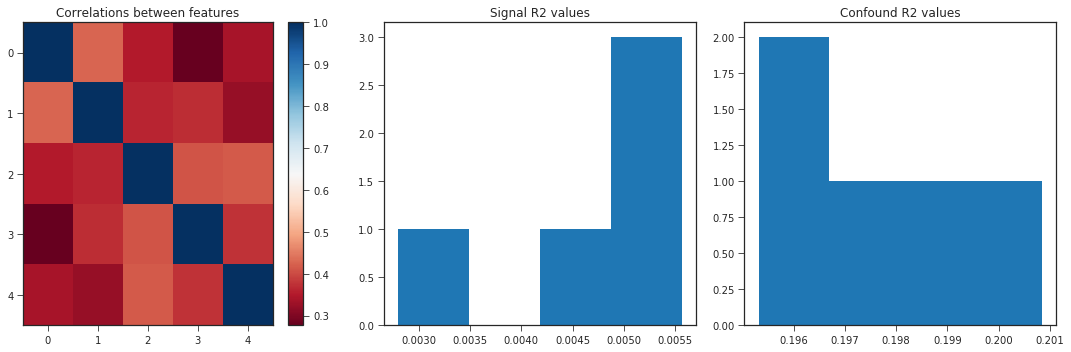

X shape: (200, 5)
y shape: (200,)
c shape: (200,)


In [4]:
data_gen = DataGenerator(N=200, K=5, corr_cy=0.65, signal_r2=0.003,
                         confound_r2=0.2, c_type='continuous', y_type='binary',
                         tolerance=0.003, verbose=True)
data_gen.generate()

X, y, c = data_gen.return_vals()
print("X shape: %r" % (X.shape,))
print("y shape: %r" % (y.shape,))
print("c shape: %r" % (c.shape,))

Below, we define several functions to quickly run classification analyses using different confound-strategies we're evaluating in this notebook:

- **None**: just run a classification analysis (predict $y$ from $X$) without treating the confound ($c$)
- **WDCR** (whole-dataset confound regression): regress out $c$ from $X$ on the whole dataset, then run a (cross-validated) classification analysis
- **FwCR** (foldwise confound regression): first regress out $c$ from $X$ per fold, then run a classification analysis (predict $y$ from $X$)
- **CB** (counterbalance): first subsample $X$ and $y$ until $\rho(yc) \approx 0$, then run a classification analysis (predict $y$ from $X$; also, it's made sure that $\rho(yc) = 0$ also in *each fold*!)

In [57]:
from utils import vectorized_semipartial_corr, vectorized_corr

def run_without_confound_control(X, y, c, pipeline, cv, arg_dict, sim_nr=None):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
        
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['None'] * n_splits
    results['sim_nr'] = [sim_nr] * n_splits
    results['score'] = cross_val_score(estimator=pipeline, X=X, y=y, cv=cv, scoring='f1_macro')
    
    return results


def run_with_ipw(X, y, c, pipeline, cv, arg_dict, sim_nr=None):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
        
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['IPW'] * n_splits
    results['sim_nr'] = [sim_nr] * n_splits

    y_ohe = OneHotEncoder(sparse=False).fit_transform(y[:, np.newaxis])
    skf = StratifiedKFold(n_splits=n_splits)
    lr = LogisticRegression(class_weight='balanced')
    
    if c.ndim == 1:
        c = c[:, np.newaxis]
    
    tmp_scores = np.zeros(n_splits)
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        lr.fit(c[train_idx], y[train_idx])
        probas = lr.predict_proba(c[train_idx])
        weights = 1 / (probas * y_ohe[train_idx]).sum(axis=1)
        pipeline.fit(X[train_idx], y[train_idx], clf__sample_weight=weights)
        preds = pipeline.predict(X[test_idx])
        tmp_scores[i] = f1_score(y[test_idx], preds, average='macro')
    
    results['score'] = tmp_scores
    
    return results


def run_with_counterbalancing(X, y, c, pipeline, cv, arg_dict, verbose=False,
                              c_type='categorical', metric='corr', threshold=0.05, use_pval=True, sim_nr=None):
    """ Run a classification analysis using without controlling for confounds.
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
    
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """

    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['CB'] * n_splits
    results['sim_nr'] = [sim_nr] * n_splits

    results_corr = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(arg_dict['K']*2)])
    results_corr['ki'] = np.tile(np.arange(arg_dict['K']), reps=2)
    results_corr['before_after'] = ['before'] * arg_dict['K'] + ['after'] * arg_dict['K']
    results_corr['sim_nr'] = [sim_nr] * arg_dict['K'] * 2
    
    corrs_xy_before = vectorized_corr(y, X)
    scorrs_xy_before = vectorized_semipartial_corr(y, c, X, which='2D')    
    scorrs_xc_before = vectorized_semipartial_corr(c, y, X, which='2D')
    
    skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=cv, c_type=c_type, verbose=verbose)
    try:
        skf.check_counterbalance_and_subsample()
    except:
        results['score'] = np.zeros(n_splits)
        corrs_xy_after = np.zeros_like(corrs_xy_before)
        scorrs_xy_after = np.zeros_like(scorrs_xy_before)
        scorrs_xc_after = np.zeros_like(scorrs_xy_before)
        
        results_corr['corr_xy'] = np.concatenate((corrs_xy_before, corrs_xy_after))
        results_corr['scorr_xy'] = np.concatenate((scorrs_xy_before, scorrs_xy_after))
        results_corr['scorr_xc'] = np.concatenate((scorrs_xc_before, scorrs_xc_after))
        
        results_corr['subsample_perc'] = 100
        return results, results_corr

    Xn, yn, cn = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    
    corrs_xy_after = vectorized_corr(yn, Xn)
    scorrs_xy_after = vectorized_semipartial_corr(yn, cn, Xn, which='2D')
    scorrs_xc_after = vectorized_semipartial_corr(cn, yn, Xn, which='2D')
    
    results_corr['corr_xy'] = np.concatenate((corrs_xy_before, corrs_xy_after))
    results_corr['scorr_xy'] = np.concatenate((scorrs_xy_before, scorrs_xy_after))
    results_corr['scorr_xc'] = np.concatenate((scorrs_xc_before, scorrs_xc_after))
    
    results_corr['subsample_perc'] = [(Xn.shape[0] - X.shape[0]) / X.shape[0]] * X.shape[1] * 2
    results['score'] = cross_val_score(estimator=pipeline, X=Xn, y=yn, cv=skf, scoring='f1_macro')
    return results, results_corr


def run_with_wholedataset_confound_regression(X, y, c, pipeline, cv, arg_dict, sim_nr=None):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : int
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)
        
    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['WDCR'] * n_splits
    results['sim_nr'] = [sim_nr] * n_splits
    
    # Regress out c from X
    cr = ConfoundRegressor(X=X, confound=c, cross_validate=True)
    X_corr = cr.fit_transform(X)
    results['score'] = cross_val_score(estimator=pipeline, X=X_corr, y=y, cv=cv, scoring='f1_macro')

    return results


def run_with_foldwise_confound_regression(X, y, c, pipeline, cv, arg_dict, sim_nr=None):
    """ Run a classification analysis using without controlling for confounds.
    
    Parameters
    ----------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : nu1mpn_sampy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values
    pipeline : Pipeline-object
        A scikit-learn Pipeline-object
    n_splits : intn_sampn_samp
        Number of splits to generate in the K-fold routine
    arg_dict : dict
        Dictionary with arguments used in data generation
        (i.e. args fed to generate_data function)

    Returns
    -------
    results : pandas DataFrame
        DataFrame with data parameters (from arg-dict) and fold-wise scores.
    """
 
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['FwCR'] * n_splits
    results['sim_nr'] = [sim_nr] * n_splits

    skf = StratifiedKFold(n_splits=n_splits)
    scores = np.zeros(n_splits)
    
    cfr = ConfoundRegressor(X=X, confound=c, cross_validate=True)
    this_pipe = deepcopy(pipeline).steps
    this_pipe.insert(0, ('regress', cfr))
    this_pipe = Pipeline(this_pipe)
    results['score'] = cross_val_score(estimator=this_pipe, X=X, y=y, cv=cv, scoring='f1_macro')
    
    return results

### Fixed parameters / settings


In [58]:
pipeline = Pipeline([

    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

n_splits = 10  # i.e. 10-fold cross-validation

## Scenario 1: what happens when we vary *confound $R^2$* and *$\rho(cy)$*?
... or, in other words, what happens when we increase the amount of confounded "signal" in X (area *C* in the venn-diagram) and the initial correlation between the confound (c) and the target (y)?

We evaluate the following values for the parameter $\rho(cy)$:
- $\rho(cy) \in \{0.25, 0.3, 0.35..., 0.85\}$

We set the range of values (in steps of 0.05) for $confound\ R^2$ dynamically, because the maximum value for $confound\ R^2$ depends on the $\rho(cy)$ parameter. For example, we cannot set $confound\ R^2 = 0.5$ when $\rho(cy) = 0.6$, because $\sqrt{0.5} > 0.6$. Thus:

- $confound\ R^2 \in \{0.00, 0.05, ..., \rho(cy)^2 - (\rho(cy)^2\ mod\ 0.05)\}$

And we'll use the following fixed parameters:
- $N = 200$
- $K = 5$
- $signal\ R^2=0.1$

Importantly, we also track the correlations $\rho(xy)$ and $\rho(xc)$ before and after counterbalancing, because there is something weird going on (as we'll explain later).

In [59]:
# We do it three times for robustness
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

simulations = 10

# Specify arguments for data generations (we'll set corr_cy and confound_r2 later)
data_args = dict(N=200, K=5, c_type='continuous', y_type='binary',
                 corr_cy=None, signal_r2=0.004, confound_r2=None,
                 verbose=False, tolerance=0.001)

# The values for corr_cy to loop over
corr_cy_vec = [0.65]

# The confound_r2 values to loop over
confound_r2_vecs = [np.arange(0, corr_cy**2 - 0.05, 0.05)
                    for corr_cy in corr_cy_vec]

signal_r2_vec = [0.004, 0.1]

# The 'reference performance' to keep track of (scores on data generated without
# any influence of the confound)
reference_performance = np.zeros((simulations, len(signal_r2_vec)))

results_gen_sim = []
results_corr_gen_sim = []

# Loop over simulations
for sim in np.arange(simulations):

    print("Simulation: %i" % (sim + 1))
    cv = StratifiedKFold(n_splits=n_splits)
    # Loop over values for corr_cy
    for i, signal_r2 in enumerate(signal_r2_vec):
        data_args.update(signal_r2=signal_r2)
        data_args.update(confound_r2=None)
        data_args.update(corr_cy=0)
        
        dgen = DataGenerator(**data_args)
        Xref, yref = dgen.generate().return_vals() 
        reference_performance[sim, i] = cross_val_score(pipeline, Xref, yref, cv=cv).mean()
        
        print("Signal r2: %.3f" % signal_r2)
        for ii, corr_cy in enumerate(corr_cy_vec):
            data_args.update(corr_cy=corr_cy)
            data_args.update(confound_r2=None)
            
            confound_r2_vec = confound_r2_vecs[ii]
            print("corr_cy: %.3f, confound_r2: [ " % corr_cy, end='')

            # Loop over values for confound_r2
            for iii, confound_r2 in enumerate(confound_r2_vec):
                print('%.3f' % confound_r2 + ' ', end='')
                data_args.update(confound_r2=confound_r2)
                dgen = DataGenerator(**data_args)
                X, y, c = dgen.generate().return_vals()
                results_gen_sim.append(run_without_confound_control(X, y, c, pipeline, cv, data_args, sim_nr=sim))
                results_gen_sim.append(run_with_wholedataset_confound_regression(X, y, c, pipeline, cv, data_args, sim_nr=sim))
                results_gen_sim.append(run_with_foldwise_confound_regression(X, y, c, pipeline, cv, data_args, sim_nr=sim))    
                
                res, corrs = run_with_counterbalancing(X, y, c, pipeline, n_splits, c_type='continuous',
                                                       arg_dict=data_args, sim_nr=sim)
                results_gen_sim.append(res)
                results_corr_gen_sim.append(corrs)
            print(']')
            
results_gen_sim_df = pd.concat(results_gen_sim)
results_corrs_gen_sim_df = pd.concat(results_corr_gen_sim)

Simulation: 1
Signal r2: 0.004
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Signal r2: 0.100
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Simulation: 2
Signal r2: 0.004
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Signal r2: 0.100
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Simulation: 3
Signal r2: 0.004
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Signal r2: 0.100
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Simulation: 4
Signal r2: 0.004
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Signal r2: 0.100
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Simulation: 5
Signal r2: 0.004
corr_cy: 0.650, confound_r2: [ 0.000 0.050 0.100 0.150 0.200 0.250 0.300 0.350 ]
Signal r2: 0.100
corr_cy: 0.650, confound_r2: [ 

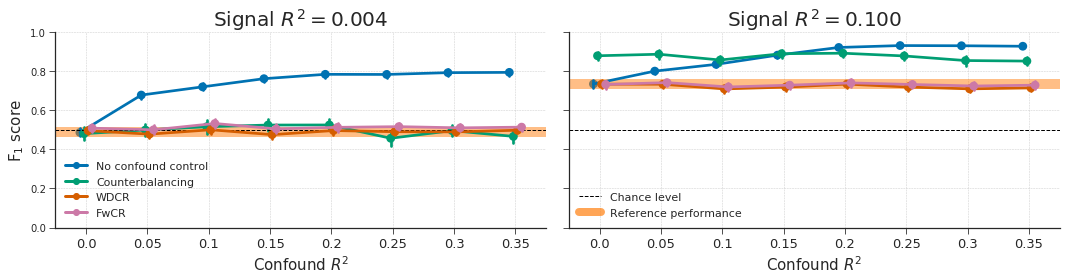

In [165]:
results_gen_sim_df = pd.concat(results_gen_sim)
results_corrs_gen_sim_df = pd.concat(results_corr_gen_sim)

custom_legend_labels = ['No confound control', 'Counterbalancing', 'WDCR', 'FwCR',
                        'Chance level', 'Reference performance']
colormap = sns.color_palette('colorblind')

custom_legend_handles = [plt.Line2D((0, 1), (0, 0), color=colormap[i], marker='o', lw=3) for i in range(4)]
custom_legend_handles.extend([
                         plt.Line2D((0, 1), (0, 0), color='k', ls='--', lw=1),
                         plt.Line2D((0, 1), (0, 0), color='tab:orange', ls='-', lw=8, alpha=0.7)])

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(15, 4))
for i, signal_r2 in enumerate(signal_r2_vec):
    tmp_df = results_gen_sim_df.query('signal_r2 == @signal_r2')
    ax = sns.pointplot(x='confound_r2', y='score', hue='method', data=tmp_df,
                        palette='colorblind', hue_order=['None', 'CB', 'WDCR', 'FwCR'], dodge=0.2,
                        ax=axes[i])
    ax.axhline(y=0.5, ls='--', c='k', lw=1)
    #ax.axhline(reference_performance[:, i].mean(axis=0), ls='--', c='orange', lw=1)
    baseline_string = 'None'
    ref_score = tmp_df.query('confound_r2 == 0.0 & method == @baseline_string').groupby('sim_nr').mean().score.values
    ref_mean, ref_std = ref_score.mean(), ref_score.std()
    #ax.axhline(ref_mean, lw=1, ls='--', c='tab:orange')
    this_xlim = np.array(ax.get_xlim())
    this_xlim[1] += 0.1
    ax.fill_between(np.arange(*this_xlim, 0.1), ref_mean + ref_std, ref_mean - ref_std,
                    facecolor='tab:orange', alpha=0.5)

    ax.set_ylim(0, 1)
    ax.grid(lw=0.5, ls='--')
    ax.set_xticklabels(np.round(confound_r2_vecs[0], 3), fontsize=13)
    ax.set_title('$\mathrm{Signal}\ R^2 = %.3f$' % signal_r2, fontsize=20)
    ax.set_xlabel('$\mathrm{Confound}\ R^2$', fontsize=15)
    if i == 1:
        ax.set_ylabel('')
        ax.legend(custom_legend_handles[4:], custom_legend_labels[4:], fontsize=11)
    else:
        ax.set_ylabel('$\mathrm{F_{1}\ score}$', fontsize=15)
        ax.legend(custom_legend_handles[:4], custom_legend_labels[:4], fontsize=11)
    
sns.despine()
fig.tight_layout()
fig.savefig('figs/generic_simulation.png', dpi=200)

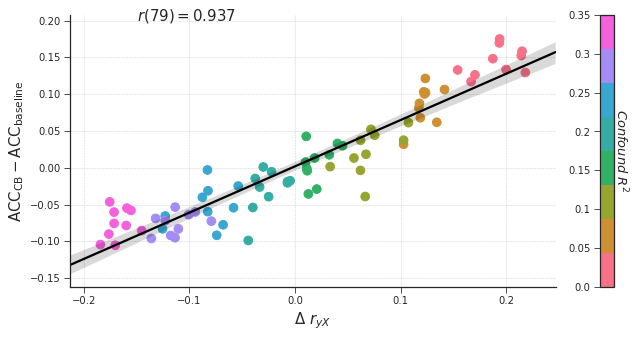

In [61]:
from matplotlib.colors import ListedColormap

tmp = results_gen_sim_df.query('signal_r2 == 0.1')
tmp = tmp.pivot_table(index=['confound_r2', 'sim_nr'], columns='method', values='score').reset_index()
tmp['diff_cb_none'] = tmp.CB - tmp['None']

tmp2 = results_corrs_gen_sim_df.query('signal_r2 == 0.1').groupby(['sim_nr', 'confound_r2', 'before_after', 'subsample_perc']).mean().reset_index()
tmp2 = tmp2.sort_values(by=['confound_r2', 'sim_nr'])
diff_xy = np.abs(tmp2[tmp2.before_after == 'after'].corr_xy.values) - np.abs(tmp2[tmp2.before_after == 'before'].corr_xy.values)

tmp['xy_diff'] = diff_xy
tmp['perc'] = tmp2[tmp2.before_after == 'after'].subsample_perc.values

fig = plt.figure(figsize=(10, 5))

cpalette = sns.color_palette("husl", n_colors=len(confound_r2_vecs[0]))
my_cmap = ListedColormap(cpalette.as_hex())
spl = plt.scatter(tmp.xy_diff, tmp.diff_cb_none, c=tmp.confound_r2, cmap=my_cmap, s=75)
ax = sns.regplot(data=tmp, x='xy_diff', y='diff_cb_none', ax=plt.gca(), scatter=False, color='k')
ax.set_xlabel('$\Delta\ r_{yX}$', fontsize=15)
ax.set_ylabel('$\mathrm{ACC_{CB} - ACC_{baseline}}$', fontsize=15)
this_corr = pearsonr(tmp.xy_diff, tmp.diff_cb_none)[0]
ax.text(-.15, .2, '$r(%i) = %.3f$' % (tmp.xy_diff.size - 1, this_corr), fontsize=15)

cb = fig.colorbar(spl, cmap=my_cmap, ax=plt.gca(), fraction=0.05, pad=0.08)
cb.ax.set_yticklabels(confound_r2_vecs[0].round(2))
cb.set_label('$Confound\ R^2$', rotation=270, labelpad=15, fontsize=13)
ax.grid(ls='--', lw=.5)
sns.despine()

sns.despine()
fig.savefig('figs/confound_r2_cb_better_than_baseline.png', dpi=200)

## Part B: counterbalancing follow-up simulation
Something weird is going on. But what? Let's find out.

In [ ]:
import importlib
import counterbalance

In [ ]:
cov = np.array([
    [1, .4, -.65],
    [.4, 1, +.4],
    [-.65, +.4, 1]
])

N = 1000
iters = 10000
orig_cb_diffs = np.zeros(iters)
highest_diff = 0

statss = dict(r_yX=[], r_yX_diff=[], sgr2=[], sgr2_diff=[], cfr=[], cfr2=[], cfr2_diff=[], scorediff=[], prop=[])

for i in tqdm_notebook(range(iters)):
    '''
    corr_xy = np.random.uniform(-.65, .65)
    corr_yc = np.random.uniform(-.65, .65)
    corr_xc = np.random.uniform(-.65, .65)
    
    cov = np.array([
        [1, corr_xy, corr_yc],
        [corr_xy, 1, corr_xc],
        [corr_yc, corr_xc, 1]
    ])
    '''
    data = np.random.multivariate_normal(np.zeros(3), cov=cov, size=N)
    y, X, c = data[:, 0], data[:, 1, np.newaxis], data[:, 2]
    y = (y > y.mean()).astype(int)
    
    cbss = counterbalance.CounterbalancedStratifiedSplit(X=X, y=y, c=c, n_splits=n_splits, c_type='continuous',
                                          metric='corr', use_pval=True, threshold=0.1)
    cbss.check_counterbalance_and_subsample()
    idx = cbss.subsample_idx
    nidx = list(set(range(y.size)) - set(idx))
    nonsel = np.zeros(y.size)
    nonsel[nidx] = 1

    Xss, yss, css = X[idx], y[idx], c[idx]
    o_score = cross_val_score(pipeline, X=X, y=y, cv=10).mean()
    cb_score = cross_val_score(pipeline, X=Xss, y=yss, cv=10).mean()
    orig_cb_diffs[i] = cb_score - o_score
    
    r_yX = pearsonr(y, X.squeeze())[0]
    r_yX_ss = pearsonr(yss, Xss.squeeze())[0]
    r_yX_diff = np.abs(r_yX_ss) - np.abs(r_yX)
    r_yX_c = vectorized_semipartial_corr(y, c, X)[0]
    r_yX_c_ss = vectorized_semipartial_corr(yss, css, Xss)[0]
    r_yX_c_diff = r_yX_c_ss - r_yX_c
    
    cfr = np.abs(r_yX) - np.abs(r_yX_c)
    
    cfr2 = r_yX ** 2 - r_yX_c ** 2
    cfr2_diff = cfr2 - (r_yX_ss ** 2 - r_yX_c_ss ** 2)
    
    prop = yss.size / y.size
    statss['prop'].append(prop)
    statss['r_yX'].append(r_yX)
    statss['r_yX_diff'].append(r_yX_diff)
    statss['sgr2'].append(r_yX_c)
    statss['sgr2_diff'].append(r_yX_c_diff)
    statss['cfr'].append(cfr)
    statss['cfr2'].append(cfr2)
    statss['cfr2_diff'].append(cfr2_diff)

    statss['scorediff'].append(orig_cb_diffs[i])
    
    if orig_cb_diffs[i] > highest_diff:
        best_X, best_y, best_c = X, y, c
        best_idx, best_nidx = idx, nidx 
        highest_diff = orig_cb_diffs[i]
        print("Highest diff: %.3f" % highest_diff)

In [ ]:
stats_df = pd.DataFrame(statss)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0] = sns.regplot(data=stats_df, x='cfr', y='r_yX_diff', ax=axes[0])
axes[0].text(0.0, 0.25, 'r(%i) = %.3f' % ((stats_df.shape[0] - 1), pearsonr(stats_df.cfr, stats_df.r_yX_diff)[0]), fontsize=15)
axes[0].set_xlabel('$|r_{yX}| - |r_{y(X.C)}|$', fontsize=15)
axes[0].set_ylabel('$|r_{yX_{before}}| - |r_{yX_{after}}|$', fontsize=15)

axes[1] = sns.regplot(data=stats_df, x='r_yX_diff', y='scorediff', ax=axes[1])
axes[1].text(-.1, .1, 'r(%i) = %.3f' % ((stats_df.shape[0] - 1), pearsonr(stats_df.r_yX_diff, stats_df.scorediff)[0]), fontsize=15)
axes[1].set_xlabel('$|r_{yX_{before}}| - |r_{yX_{after}}|$', fontsize=15)
axes[1].set_ylabel('acc(CB) - acc(baseline)', fontsize=15)

sns.despine()

stats_df.corr()

In [ ]:
orig_score = cross_val_score(pipeline, X=best_X, y=best_y, cv=n_splits).mean()
cb_score = cross_val_score(pipeline, X=best_X[best_idx], y=best_y[best_idx], cv=n_splits).mean()

In [ ]:
import matplotlib as mpl

def plot_contours_and_decision_boundary(ax, X, y, clf, cmap, xlim=(-4, 4), ylim=(-4, 4)):
    clf.fit(X, y)
    w = clf.coef_[0]
    x_0 = -clf.intercept_[0] / w[0]
    ax.axvspan(xlim[0], x_0, facecolor=cmap(0), alpha=0.5, zorder=1)
    ax.axvspan(x_0, xlim[1], facecolor=cmap(1), alpha=0.5, zorder=1)
    ax.axvline(x=x_0, c='k', ls='--', lw=2)
    return ax, x_0

sns_map = sns.color_palette('colorblind')
cmap = mpl.colors.ListedColormap([sns_map[5], sns_map[1]])
y1_col, y0_col = cmap(1), cmap(0)

custom_legend_handles = [
    plt.Line2D((0,1),(0,0), color=cmap(0), marker='o', linestyle='', mec='k', mew=.5, markersize=20),
    plt.Line2D((0,1),(0,0), color=cmap(1), marker='o', linestyle='', mec='k', mew=.5, markersize=20),
    plt.Line2D((0,1),(0,0), color=cmap(0), marker='o', linestyle='', mec='r', mew=3, markersize=20),
    plt.Line2D((0,1),(0,0), color='k', ls='--', lw=3)
]

custom_legend_labels = ['y = 0', 'y = 1', 'Rejected after subsampling', 'Decision boundary']

fig = plt.figure(figsize=(25, 25))
xlim, ylim = (-4, 4), (-4, 4)

# XY KDE PLOT (UPPER)
ax0 = plt.subplot2grid((13, 5), (0, 0), colspan=4, rowspan=2)
ax0 = sns.kdeplot(data=best_X[best_y == 1].squeeze(), shade=True, color=y1_col, ax=ax0)
ax0 = sns.kdeplot(data=best_X[best_y == 0].squeeze(), shade=True, color=y0_col, ax=ax0)

ax0.set_xlim(xlim)
ax0.axis('off')

# SCATTER PLOT (BEFORE)
ax1 = plt.subplot2grid((13, 5), (2, 0), colspan=4, rowspan=4)
ax1, x_0 = plot_contours_and_decision_boundary(ax=ax1, X=best_X, y=best_y, cmap=cmap, clf=SVC(kernel='linear'))
ax1.scatter(best_X[best_idx], best_c[best_idx], c=best_y[best_idx],
            cmap=cmap, edgecolor='black', linewidth=.8, s=175, zorder=2)
ax1.scatter(best_X[best_nidx], best_c[best_nidx], c=best_y[best_nidx],
            cmap=cmap, edgecolor='red', linewidth=0.8, s=175, zorder=2)
ax1.text(2, -3.5, "Accuracy: %.3f" % orig_score, fontsize=30)
ax1.set_ylabel("C", fontsize=40)
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.legend(custom_legend_handles, custom_legend_labels, fontsize=25, loc=2)
ax1.tick_params(labelsize=20)
ax0.axvline(x_0, c='k', ls='--')

l1 = mpl.patches.FancyArrow(0.145, .6, 0, -.2, transform=fig.transFigure, figure=fig,
                            width=0.03, color='grey', head_length=0.075, ec='red', linewidth=2)
fig.patches.extend([l1])

# EMPTY PLOT
ax_tmp = plt.subplot2grid((13, 5), (6, 0), colspan=4, rowspan=1)
ax_tmp.text(0.5, 0.4, 'X', fontsize=45)
ax_tmp.text(0.155, 0.4, 'Subsampling', fontsize=32)
ax_tmp.axis('off')

# SCATTER PLOT (AFTER)
ax2 = plt.subplot2grid((13, 5), (7, 0), rowspan=4, colspan=4)
ax2, x_0 = plot_contours_and_decision_boundary(ax=ax2, X=best_X[best_idx], y=best_y[best_idx], cmap=cmap,
                                               clf=SVC(kernel='linear'))
ax2.scatter(best_X[best_idx], best_c[best_idx], c=best_y[best_idx],
            cmap=cmap, edgecolor='black', linewidth=.8, s=175, zorder=2)
ax2.text(2, -3.5, "Accuracy: %.3f" % cb_score, fontsize=30)
ax2.set_ylabel("C", fontsize=40)
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.xaxis.set_ticks_position('top')
ax2.tick_params(labelsize=20)

# XY KDE PLOT (LOWER)
ax3 = plt.subplot2grid((13, 5), (11, 0), colspan=4, rowspan=2)
ax3 = sns.kdeplot(data=best_X[best_idx][best_y[best_idx] == 1].squeeze(), shade=True, color=y1_col, ax=ax3)
ax3 = sns.kdeplot(data=best_X[best_idx][best_y[best_idx] == 0].squeeze(), shade=True, color=y0_col, ax=ax3)
ax3.axvline(x_0, c='k', ls='--')
ax3.invert_yaxis()
ax3.set_xlim(xlim)
ax3.axis('off')

# XC KDE PLOT (UPPER)
ax4 = plt.subplot2grid((13, 5), (2, 4), rowspan=4)
ax4 = sns.kdeplot(data=best_c[best_y == 1], shade=True, color=y1_col, ax=ax4, vertical=True)
ax4 = sns.kdeplot(data=best_c[best_y == 0], shade=True, color=y0_col, ax=ax4, vertical=True)
ax4.axis('off')

# XY KDE PLOT (LOWER)
ax5 = plt.subplot2grid((13, 5), (7, 4), rowspan=4)
ax5 = sns.kdeplot(data=best_c[best_idx][best_y[best_idx] == 1], vertical=True, color=y1_col, ax=ax5, shade=True)
ax5 = sns.kdeplot(data=best_c[best_idx][best_y[best_idx] == 0], vertical=True, color=y0_col, ax=ax5, shade=True)
ax5.axis('off')

fig.tight_layout(w_pad=-2, h_pad=-3.5)
fig.savefig('figs/cb_issue_plot.png', dpi=200, bbox_inches='tight')

Can we quantify this? Let's do it using the same method as applied to the empirical data: run a cross-validated decoding analysis on the retained data and *also* cross-validate the model to the rejected data, keeping track of the predictions (to calculate the proportion correct) and the distance to the classification boundary. Because the repeated prediction of the rejected data, we derive the final predictions of each sample in the rejected data as the mode of the predictions (this is, essentially, doing a majority vote prediction).

In [ ]:
from scipy.stats import ttest_ind, chisquare
from statsmodels.stats.proportion import proportions_chisquare

Xss, yss, css = best_X[best_idx], best_y[best_idx], best_c[best_idx]
Xnss, ynss, cnss = best_X[best_nidx], best_y[best_nidx], best_c[best_nidx]

skf = StratifiedKFold(n_splits=10)
clf = SVC(kernel='linear')
scaler = StandardScaler()

dtb_ss = np.zeros(len(best_idx))
preds_ss = np.zeros(len(best_idx))
dtb_nss = np.zeros((len(best_nidx), 10))
preds_nss = np.zeros((len(best_nidx), 10))

for i, (train_idx, test_idx) in enumerate(skf.split(Xss, yss)):
    X_train, X_test = Xss[train_idx], Xss[test_idx]
    y_train, y_test = yss[train_idx], yss[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    this_Xnss = scaler.transform(Xnss)
    clf.fit(X_train, y_train)
    dtb_ss[test_idx] = clf.decision_function(X_test)
    preds_ss[test_idx] = clf.predict(X_test)
    dtb_nss[:, i] = clf.decision_function(this_Xnss)
    preds_nss[:, i] = clf.predict(this_Xnss)
    
correct_ss = (preds_ss == yss)
correct_nss = preds_nss.max(axis=1) == ynss  # majority vote
correct_nss = (correct_nss > 0.5).astype(int)
print("Proportion correct subsampled: %.3f" % (correct_ss.sum() / correct_ss.size))
print("Proportion correct not-subsampled: %.3f" % (correct_nss.sum() / correct_nss.size))

chiSq, pchi = proportions_chisquare(count=(correct_ss.sum(), correct_nss.sum()), nobs=(correct_ss.size, correct_nss.size))[:2]
print("Chi: %.3f (p = %.3E)" % (chiSq, pchi), end='\n\n')

yss_tmp = yss.copy()
yss_tmp[yss == 0] = -1
dist_ss = dtb_ss * yss_tmp
print("Mean distance from boundary subsampled: %.3f" % dist_ss.mean())

ynss_tmp = ynss.copy()
ynss_tmp[ynss == 0] = -1
dist_nss = dtb_nss.mean(axis=1) * ynss_tmp
print("Mean distance from boundary not-subsampled: %.3f" % dist_nss.mean())

print(ttest_ind((dtb*y_tmp)[nonsel == 0], (dtb*y_tmp)[nonsel == 1]))

We can also do it in a slightly different way: fit a (cross-validated) model on *all* the data and then compare the proportion correct and distance to boundary for the samples that *would have been retained/rejected*. Very similar to the procedure above, but slightly different because the model is based on a mix of the would-have-been-rejected and would-have-been-retained samples.

In [ ]:
from scipy.stats import ttest_ind, chisquare
dtb = np.zeros(N)
preds = np.zeros(N)

skf = StratifiedKFold(n_splits=10)
clf = SVC(kernel='linear')
scaler = StandardScaler()
for i, (train_idx, test_idx) in enumerate(skf.split(best_X, best_y)):
    X_train, X_test = best_X[train_idx], best_X[test_idx]
    y_train, y_test = best_y[train_idx], best_y[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, y_train)
    dtb[test_idx] = clf.decision_function(X_test)
    preds[test_idx] = clf.predict(X_test)
    
correct = (preds == best_y)

nonsel = np.zeros(N)
nonsel[best_nidx] = 1
y_tmp = best_y.copy()
y_tmp[best_y == 0] = -1

print("Mean retained samples: %.3f (%.3f)" % ((dtb*y_tmp)[nonsel == 0].mean(), (dtb*y_tmp)[nonsel == 0].std()))
print("Mean rejected samples: %.3f (%.3f)" % ((dtb*y_tmp)[nonsel == 1].mean(), (dtb*y_tmp)[nonsel == 1].std()))

print(ttest_ind((dtb*y_tmp)[nonsel == 0], (dtb*y_tmp)[nonsel == 1]))
observed_count = (correct[nonsel == 0].sum(), correct[nonsel == 1].sum())
print(1 - np.array(observed_count) / np.array([(nonsel == 0).sum(), (nonsel == 1).sum()]))
print(chisquare(observed_count))

In the paper we report the results from the first method to keep it consistent with this analysis of the empirical data (which can only be done using the first method because of the complication due to the feature selection procedure).

## Part C: WDCR/FwCR follow-up simulations
Now, we delve into the issue of below-chance classification we observe when regressing out the confound from the entire dataset at once. We'll demonstrate this issue by some simulations on random (normal) data.

Suppose you generate random (normal) data of shape $N\ (samples) \times K\ (features)$  - let's call this $X$ - and a vector with binary values (0 or 1) of shape $N \times K$ - let's call this $y$. Suppose you then implement a cross-validated analysis, in which you fit a linear model (e.g. a linear SVM) iteratively in a (let's say) 10-fold cross-validation scheme. Now, suppose you simulate this 1000 times. (Note that this is very similar to the permutation statistics people employ to calculate non-parametric p-values for their classification scores.) You expect the distribution of your (e.g.) accuracy scores to be centered around 50%. However, you'll undoubtedly observe some scores below 50%. Can we characterize *why* some random generations lead to below chance classifications while others don't, beyond just saying it's just occuring randomly? Let's try.

Remember, linear classifiers are capitalizing on some linear statistical dependence between the features in X and y. This can be (per feature) expressed as the correlation between X and y. When randomly generating data (or, perhaps equivalently, when doing permutation analyses), you will observe a *distribution* of correlations between your features and y. In the following simulations, we'll show you that **relatively narrow distributions of these correlations** (i.e., narrower than you'd expect by chance) **lead to relatively low accuracy scores**. Data corresponding to these relatively narrow distributions are, then, more prone to yield "oppsing statistical dependencies" (i.e. flipped signs of correlations) between the train and test-set, resulting in below-chance accuracies. 

To show this association between (below chance) accuracy and the standard deviation of the distribution of correlations between features and y *in general*, we've written a simple simulation below. We generate random (normal) data for our $X$ matrix and a vector with random (0, 1) values for y for a given `n_sims` simulations. For each simulation, we keep track of accuracy (averaged over `n_folds`), the initial standard deviation of the correlations between $X$ and $y$ (averaged over `k_feat` in X), and the proportion of "sign-flips" we observe between the correlation of features and y in the train and test-set. 

In [62]:
from utils import vectorized_corr
def simulate_and_classify_random_data(n_sims, n_samp, k_feat, n_folds, n_repeats, dist='normal'):
    """ Simulate classification of random data.
    
    Simulate classification of random data, in which X is of
    shape (n_samp, k_feat) and consists of values from a random
    normal distribution with mean 0 and unit variance.
    The target, y, is a vector with binary (values )
    
    Parameters
    ----------
    n_sims : int
        Number of (iterations of) simulations to run.
    n_samp : int
        Number of samples (preferably an even number to keep the classes in
        y balanced).
    k_feat : int
        Number of features in X.
    n_folds : int
        Number of folds in a (Repeated) KFold cross-validation scheme 
        (in which the number of repetitions is set to 10 for robustness).
    
    Returns
    -------
    acc : dict
        A dictionary with keys 'accuracy', 'std_corr' (stdev of initial correlation
        between features and y), and 'sign_change' (the proportion of features that 
        change sign of their correlation with y between train and test)
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear'))
    ])

    skf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=np.random.randint(100000))

    results = {'accuracy': [],
               'std_corrs': [],
               'prop_sign_changes': [],
               'weighted_diff_train_test_corrs': []}

    acc = np.zeros((n_sims, n_folds * n_repeats))
    for i in tqdm_notebook(range(n_sims)):
        
        if dist == 'normal':
            X = np.random.normal(0, 1, size=(n_samp, k_feat))
        elif dist == 'uniform':
            X = np.random.normal(-1, 1, size=(n_samp, k_feat))
        elif dist == 'gamma':
            X = np.random.gamma(2, 3, size=(n_samp, k_feat))
        else:
            raise ValueError('Please choose normal or uniform or gamma!')
        
        y = np.repeat([0, 1], repeats=int(n_samp / 2))
        
        std_corr = vectorized_corr(y, X).std()
        results['std_corrs'].append(std_corr)
        
        sign_changes = np.zeros(n_folds * n_repeats)
        weighted_diffs = np.zeros(n_folds * n_repeats)
        
        for ii, (train_idx, test_idx) in enumerate(skf.split(X, y)):

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            pipe.fit(X_train, y_train)
            acc[i, ii] = pipe.score(X_test, y_test)
            
            fitted_clf = pipe.get_params(deep=False)['steps'][1][1]
            corr_train = vectorized_corr(y_train, X_train)
            corr_test = vectorized_corr(y_test, X_test)
            sign_changes[ii] = (np.sign(corr_train) != np.sign(corr_test)).sum() / k_feat
            weighted_diffs[ii] = ((corr_train - corr_test) * fitted_clf.coef_).mean()
            
        results['accuracy'].append(acc[i, :].mean())
        results['prop_sign_changes'].append(sign_changes.mean())
        results['weighted_diff_train_test_corrs'].append(weighted_diffs.mean())
        
    return results

Below, we simulate 500 datasets with 100 samples and 50 features, which are analyzed with a linear SVM in a 10-fold cross-validation scheme (repeated 10 times for robustness using [RepeatedStratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold)). We then plot a scatterplot (and linear fit) between accuracy and standard deviation of correlations (left plot), between accuracy and the proportion of sign-flips we observe (middle plot), and the average (across features) difference in correlation between train-set and test-set, weighted by the coefficient from the fit (as a more sophisticated measure of "sign flipping").

In [ ]:
results = simulate_and_classify_random_data(n_sims=100, n_samp=100, k_feat=200, n_folds=10, n_repeats=10)
results_df = pd.DataFrame(results)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(15, 5))
ax = sns.regplot(y='accuracy', x='std_corrs', data=results_df, ax=axes[0])
ax.set_xlabel('$\mathrm{\hat{\sigma}\ correlation\ distribution}$')
ax.set_ylabel('Accuracy')
ax.set_ylim(.2, 0.8)

ax = sns.regplot(y='accuracy', x='weighted_diff_train_test_corrs', data=results_df, ax=axes[1])
ax.set_xlabel('Weighted train/test difference')
ax.set_ylabel('')
ax.set_ylim(.2, 0.8)
ax.set_xlim(0.0025, 0.0075)

sns.despine()

fig.tight_layout()

As you can see, higher initial correlations lead to above chance accuracy, but importantly (absolute) correlations close(r) to zero lead to below chance classifications (upper left plot). 

This is fine in this simulation, because we can simulate this many times, across which the mean accuracy is about 50% (y-coordinates of centroid in scatterplots). But you also see that below an average standard deviation of correlation across features between X and y of 0.01, below-chance accuracies tend to occur. 

### When exactly do you get below-chance accuracy?
In the left plot above, you can see that around a standard deviation of 0.1 we get 50% correct (chance-level) and below that standard deviation you get below-chance accuracy. It turns out that this observation makes sense when we relate it the the analytic correlation distribution. The probability density function (PDF; $f(r)$) of any given correlation population parameter $r$ between bivariate normal data of shape $(n)$ is defined as:

\begin{align}
f(r) = \frac{(n - 2)\mathbf{\Gamma}(n - 1)(1 - \rho^2)^{\frac{n-1}{2}}(1 - r^2)^{\frac{n-4}{2}}}{\sqrt{2\pi}\mathbf{\Gamma}(n - \frac{1}{2})(1 - \rho r)^{n - \frac{3}{2}}}\mathbf{{_2}F_{1}}(\frac{1}{2}, \frac{1}{2};\frac{2n - 1}{2}; \frac{\rho r + 1}{2})
\end{align}

Now, we implement this pdf as follows:

In [71]:
from utils import rpdf
rpdf??

Signature: rpdf(rho, n, rs)
Source:   
def rpdf(rho, n, rs):
    """ rho = population correlation coefficient. """
    lnum = np.log(n-2) + gammaln(n-1) + np.log((1-rho**2)**(.5*(n-1))) + np.log((1-rs**2)**(.5*(n-4)))
    lden = np.log(np.sqrt(2*np.pi)) + gammaln(n-.5) + np.log((1-rho*rs)**(n-3/2))
    fac = lnum - lden
    hyp = hyp2f1(.5, .5, (2*n-1)/2, (rho*rs+1)/2)
    return np.exp(fac) * hyp
File:      /media/lukas/goliath/MVCA/analyses/utils.py
Type:      function


/home/lukas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


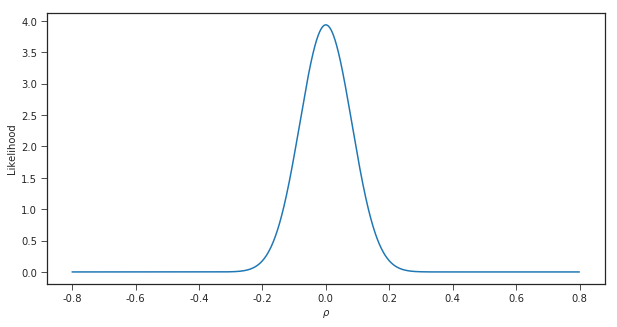

In [72]:
N = 100
rs = np.arange(-1, 1, .001)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(rpdf(rho=0, n=N, rs=rs))
ax.set_xticklabels(np.round(rs[::200], 1))
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Likelihood')
fig.show()

Now, in order to determine the expected standard deviation of the pdf of a given value for $\rho$, we can sample from the corresponding inverted CDF (also known as quantile function) by inputting numbers from a uniform distribution. We can then calculte the standard deviation of the output of the inverted CDF to determine the expected standard deviation for that particular value for $\rho$. 

Let's first define and plot the inverted CDF:

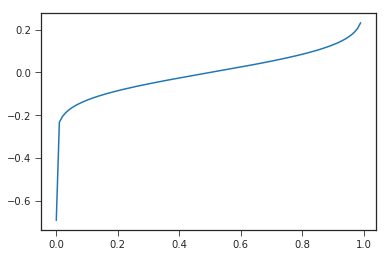

In [73]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

xs = np.random.uniform(0, 1, 10000)
rs = np.arange(-1, 1, .001)
ys = rpdf(0, N, rs)
cdf = ECDF(ys)
inverted_edf = interp1d(np.cumsum(ys[ys>0])/np.sum(ys[ys>0]), rs[ys>0], bounds_error=False)

x = np.arange(-1, 1, .01)
y = inverted_edf(x)
plt.plot(x, y)
plt.show()

Now, let's sample from this inverted CDF with random uniform numbers as inputs:

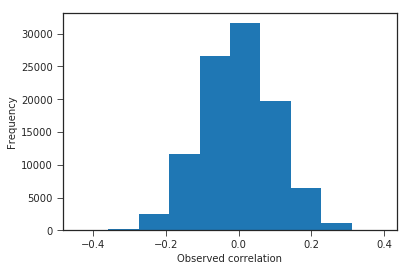

In [74]:
samples = np.random.uniform(0, 1, 100000)
samples_transformed = inverted_edf(samples)

plt.hist(samples_transformed)
plt.xlabel("Observed correlation")
plt.ylabel("Frequency")
plt.show()

Now, we can approximate the expected standard deviation for a given $\rho$ (here: $\rho = 0$) by calculating the standard deviation of the observed samples:

In [75]:
std_rho_0 = np.std(samples_transformed)
print('Standard deviation when rho = 0: %.3f' % std_rho_0)

Standard deviation when rho = 0: 0.100


This seems to check out for our randomly generated (normally distributed) data, which indeed was at chance when the standard deviation was 0.1. Given that the pdf of the correlation distribution depends on $N$ (number of samples), let simulate some new data with another value for $N$, let's say 50.

In [ ]:
corr1, pval1 = pearsonr(results_df.std_corrs, results_df.accuracy)
corr2, pval2 = pearsonr(results_df.weighted_diff_train_test_corrs, results_df.accuracy)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(15, 5))
ax = sns.regplot(y='accuracy', x='std_corrs', data=results_df, ax=axes[0])
ax.set_xlabel('$\mathrm{sd}(r_{yX})$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_ylim(.2, 0.8)
ax.set_xlim(0.08, 0.12)
ax.text(0.0815, 0.74, 'A', fontsize=30)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=13)
ax.set_xticklabels(np.round(ax.get_xticks(), 3), fontsize=13)
ax.grid(ls='--', lw=.5)
ax.annotate(r'$\sigma(pdf_{\rho = 0})$', fontsize=15, xy=(std_rho_0, 0.2), xytext=(0.1025, 0.25), arrowprops=dict(arrowstyle="->", facecolor='black', linewidth=2))
ax.text(0.1075, 0.75, '$r(499) = %.3f$' % corr1, fontsize=17)

design = np.hstack((np.ones((results_df.shape[0], 1)),
                    results_df.std_corrs[:, np.newaxis]))
betas = np.linalg.lstsq(design, results_df.accuracy)[0]
pred_acc = std_rho_0 * betas[1] + betas[0]
ax.plot([std_rho_0, std_rho_0], [0, pred_acc], c='k', ls='--', lw=1.5)
ax.plot([0, std_rho_0], [pred_acc, pred_acc], c='k', ls='--', lw=1.5)

ax = sns.regplot(y='accuracy', x='weighted_diff_train_test_corrs', data=results_df, ax=axes[1])
ax.set_xlabel('Weighted train/test difference', fontsize=15)
ax.set_ylabel('')
ax.set_ylim(.2, 0.8)
ax.set_xlim(0.00325, 0.0075)
ax.text(0.0034, 0.74, 'B', fontsize=30)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=13)
ax.set_xticklabels(np.round(ax.get_xticks(), 4), fontsize=13)
ax.grid(ls='--', lw=.5)
ax.text(0.006, 0.75, '$r(499) = %.3f$' % corr2, fontsize=17)

sns.despine()
fig.tight_layout()
fig.savefig('figs/corr_stdcorrs_accuracy_main.png', dpi=200)

Does it also work for different values of $N$?

In [ ]:
Ns = [20, 50, 100, 200, 400]
results_list = []
for N in Ns:
    print(N)
    tmp = pd.DataFrame(simulate_and_classify_random_data(n_sims=500, n_samp=N, k_feat=200, n_folds=10, n_repeats=10))
    tmp['N'] = [N] * tmp.shape[0]
    results_list.append(tmp)
results_diff_N = pd.concat(results_list)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=False, sharex=False, figsize=(15, 4))

for i, N in enumerate(Ns):
    tmp_df = results_diff_N.query('N == @N')
    ax = axes[i]
    ax.set_xlim(tmp_df.std_corrs.min() - 0.01, tmp_df.std_corrs.max() + 0.01)
    ax = sns.regplot(y='accuracy', x='std_corrs', data=tmp_df, ax=ax)
    ax.set_xlabel('$\mathrm{sd}(r_{yX})$', fontsize=15)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title('N = %i' % N, fontsize=20)
    
    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=15)
    else:
        ax.set_ylabel('')
    
    ys = rpdf(0, N, rs)
    cdf = ECDF(ys)
    inverted_edf = interp1d(np.cumsum(ys[ys>0])/np.sum(ys[ys>0]), rs[ys>0], bounds_error=False)
    samples_transformed = inverted_edf(samples)
    this_std = np.std(samples_transformed)
    design = np.hstack((np.ones((tmp_df.shape[0], 1)),
                        tmp_df.std_corrs[:, np.newaxis]))
    betas = np.linalg.lstsq(design, tmp_df.accuracy)[0]
    pred_acc = this_std * betas[1] + betas[0]
    ax.plot([this_std, this_std], [0, pred_acc], c='k', ls='--', lw=1.5)
    ax.plot([0, this_std], [pred_acc, pred_acc], c='k', ls='--', lw=1.5)
    
sns.despine()
fig.tight_layout()
fig.savefig('figs/corr_stdcorr_accuracy_diff_N.png', dpi=200)

And different sizes of the folds?

In [ ]:
n_folds = [2, 5, 10, 50]
results_list = []
for n_fold in n_folds:
    tmp = pd.DataFrame(simulate_and_classify_random_data(n_sims=500, n_samp=100, k_feat=200, n_folds=n_fold, n_repeats=10))
    tmp['n_folds'] = [n_fold] * tmp.shape[0]
    results_list.append(tmp)
results_diff_nfolds = pd.concat(results_list)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=False, sharex=False, figsize=(15, 4))

for i, nf in enumerate(n_folds):
    tmp_df = results_diff_nfolds.query('n_folds == @nf')
    ax = axes[i]
    ax.set_xlim(tmp_df.std_corrs.min() - 0.01, tmp_df.std_corrs.max() + 0.01)
    ax = sns.regplot(y='accuracy', x='std_corrs', data=tmp_df, ax=ax)
    ax.set_xlabel('$\mathrm{sd}(r_{yX})$', fontsize=15)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title('Size test-set: %i%%' % ((1/nf) * 100), fontsize=20)
    
    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=15)
    else:
        ax.set_ylabel('')
    
    ys = rpdf(0, 100, rs)
    cdf = ECDF(ys)
    inverted_edf = interp1d(np.cumsum(ys[ys>0])/np.sum(ys[ys>0]), rs[ys>0], bounds_error=False)
    samples_transformed = inverted_edf(samples)
    this_std = np.std(samples_transformed)
    design = np.hstack((np.ones((tmp_df.shape[0], 1)),
                        tmp_df.std_corrs[:, np.newaxis]))
    betas = np.linalg.lstsq(design, tmp_df.accuracy)[0]
    pred_acc = this_std * betas[1] + betas[0]
    ax.plot([this_std, this_std], [0, pred_acc], c='k', ls='--', lw=1.5)
    ax.plot([0, this_std], [pred_acc, pred_acc], c='k', ls='--', lw=1.5)
    ax.grid(ls='--', lw=.5)
    
sns.despine()
fig.tight_layout()
fig.savefig('figs/corr_stdcorr_accuracy_diff_folds.png', dpi=200)

And what about different distributions?

In [ ]:
results_unif = simulate_and_classify_random_data(n_sims=500, n_samp=100, k_feat=200, n_folds=10, n_repeats=10, dist='uniform')
results_unif_df = pd.DataFrame(results_unif)

results_gamma = simulate_and_classify_random_data(n_sims=500, n_samp=100, k_feat=200, n_folds=10, n_repeats=10, dist='gamma')
results_gamma_df = pd.DataFrame(results_gamma)

In [ ]:
results_unif_df['dist'] = ['unif'] * results_unif_df.shape[0]
results_gamma_df['dist'] = ['gamma'] * results_gamma_df.shape[0]

results_diff_dist = pd.concat((results_unif_df, results_gamma_df))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(15, 4))

for i, dist in enumerate(['unif', 'gamma']):
    tmp_df = results_diff_dist.query('dist == @dist')
    ax = axes[i]
    ax.set_xlim(tmp_df.std_corrs.min() - 0.01, tmp_df.std_corrs.max() + 0.01)
    ax = sns.regplot(y='accuracy', x='std_corrs', data=tmp_df, ax=ax)
    ax.set_xlabel('$\mathrm{sd}(r_{yX})$', fontsize=15)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title('Generative distribution: %s' % dist, fontsize=20)
    
    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=15)
    else:
        ax.set_ylabel('')
    
    ys = rpdf(0, 100, rs)
    cdf = ECDF(ys)
    inverted_edf = interp1d(np.cumsum(ys[ys>0])/np.sum(ys[ys>0]), rs[ys>0], bounds_error=False)
    samples_transformed = inverted_edf(samples)
    this_std = np.std(samples_transformed)
    design = np.hstack((np.ones((tmp_df.shape[0], 1)),
                        tmp_df.std_corrs[:, np.newaxis]))
    betas = np.linalg.lstsq(design, tmp_df.accuracy)[0]
    pred_acc = this_std * betas[1] + betas[0]
    ax.plot([this_std, this_std], [0, pred_acc], c='k', ls='--', lw=1.5)
    ax.plot([0, this_std], [pred_acc, pred_acc], c='k', ls='--', lw=1.5)
    ax.grid(ls='--', lw=.5)
    
sns.despine()
fig.tight_layout()
fig.savefig('figs/corr_stdcorr_accuracy_diff_distr.png', dpi=200)

In [ ]:
Ks = [10, 100, 1000, 10000]
results_list = []
for K in Ks:
    tmp = pd.DataFrame(simulate_and_classify_random_data(n_sims=500, n_samp=100, k_feat=K, n_folds=10, n_repeats=10))
    tmp['K'] = [K] * tmp.shape[0]
    results_list.append(tmp)
results_diff_K = pd.concat(results_list)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=False, sharex=False, figsize=(15, 4))

for i, K in enumerate(Ks):
    tmp_df = results_diff_K.query('K == @K')
    ax = axes[i]
    ax.set_xlim(tmp_df.std_corrs.min() - 0.01, tmp_df.std_corrs.max() + 0.01)
    ax = sns.regplot(y='accuracy', x='std_corrs', data=tmp_df, ax=ax)
    ax.set_xlabel('$\mathrm{sd}(r_{yX})$', fontsize=15)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title('K: %i' % K, fontsize=20)
    
    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=15)
    else:
        ax.set_ylabel('')
    
    ys = rpdf(0, 100, rs)
    cdf = ECDF(ys)
    inverted_edf = interp1d(np.cumsum(ys[ys>0])/np.sum(ys[ys>0]), rs[ys>0], bounds_error=False)
    samples_transformed = inverted_edf(samples)
    this_std = np.std(samples_transformed)
    design = np.hstack((np.ones((tmp_df.shape[0], 1)),
                        tmp_df.std_corrs[:, np.newaxis]))
    betas = np.linalg.lstsq(design, tmp_df.accuracy)[0]
    pred_acc = this_std * betas[1] + betas[0]
    ax.plot([this_std, this_std], [0, pred_acc], c='k', ls='--', lw=1.5)
    ax.plot([0, this_std], [pred_acc, pred_acc], c='k', ls='--', lw=1.5)
    ax.grid(ls='--', lw=.5)
    
sns.despine()
fig.tight_layout()
fig.savefig('figs/corr_stdcorr_accuracy_diff_K.png', dpi=200)

### Artificially narrowing the correlation distribution leads to below-chance accuracy
We think exactly this is happening when you regress out your confound on the entire dataset: you artificially narrow the correlation distribution, which leads to an increase in sign-flips and thus negative bias. If the correlation distribution becomes more narrow than expected by chance, below-chance accuracy will follow.

We follow-up on this idea with another simulation. Here, we actively control the standard deviation of the correlations between X and y. We test a range of these correlations and show that lower average absolute correlations yield (relatively) more negative bias (i.e. dip more below chance):

In [ ]:
from utils import vectorized_corr

def simulate_and_classify_data_constrained(n_sims, n_samp, k_feat, n_folds,
                                           std_corr=None, verbose=False):
    """ Simulate classification of random data.
    
    Simulate classification of random data, in which X is of
    shape (n_samp, k_feat) and consists of values from a random
    normal distribution with mean 0 and unit variance. The data generation
    is constrained by 'mean_corr' (the average absolute correlation between
    features and y) or 'std_corr' (the standard deviation of correlations between
    features and y). The target, y, is a vector with binary values.
    
    Parameters
    ----------
    n_sims : int
        Number of (iterations of) simulations to run.
    n_samp : int
        Number of samples (preferably an even number to keep the classes in
        y balanced).
    k_feat : int
        Number of features in X.
    n_folds : int
        Number of folds in a (Repeated) KFold cross-validation scheme 
        (in which the number of repetitions is set to 10 for robustness).
    std_corr : float or None
        If float, the standard deviation of correlations between features and
        y will be constrained by this number (+- 0.001 margin of error).
        If None, the number for mean_corr will be used to constrain
        data generation. 
    
    Returns
    -------
    acc : numpy array (of length n_sims)
        Array with average scores (across folds) for n_sims.
        
    Raises
    ------
    ValueError
        If both mean_corr and std_corr are set to None.
    """
     
    if verbose:
        iterator = tqdm_notebook(range(n_sims), desc='%.3f/%i' % (std_corr, k_feat))
    else:
        iterator = range(n_sims)

    # Pipeline
    pipe = Pipeline([('scale', StandardScaler()), 
                     ('svc', SVC(kernel='linear'))])

    acc = np.zeros(n_sims)
    for i in iterator:
        
        break_out = False
        
        # Generate y first
        y = np.repeat([0, 1], repeats=int(n_samp / 2))
        
        attempt = 0
        while True:
            X = np.random.normal(0, 1, size=(n_samp, k_feat))
            
            corrs = vectorized_corr(y, X)
            this_std = np.std(corrs)
            std_found = np.abs(this_std - std_corr) < 0.001
            
            if std_found:
                break
                
            attempt += 1
            
            if (attempt + 1) % 10000 == 0:
                # If it's stuck (likely for many features), let's help it a little bit
                while True:
                
                    upper, lower = np.mean(corrs) + np.std(corrs), np.mean(corrs) - np.std(corrs)
                    if (this_std - std_corr) < 0:
                        # Std must be increased    
                        idx = np.logical_and(corrs < upper, corrs > lower)
                    else:
                        # Std must be decreased
                        idx = np.logical_or(corrs > upper, corrs < lower)
                    
                    new_X = np.random.normal(0, 1, size=(n_samp, idx.sum()))
                    X[:, idx] = new_X
                    
                    corrs = vectorized_corr(y, X)
                    this_std = np.std(corrs)
                    std_found = np.abs(this_std - std_corr) < 0.001
                    
                    if std_found:
                        break_out = True
                        break
                        
            if break_out:
                break
                
        # 10-fold stratified CV
        cv = StratifiedKFold(n_splits=n_folds)

        # Cross-validate and predict
        scores = cross_val_score(pipe, X, y, cv=cv)
        acc[i] = scores.mean()
        
    return acc

We'll call the function from above with different values `std_corr` and, while we're at it, diffferent amounts of features (`k_feat`).
Probably for supplementary figures.

In [ ]:
std_corrs = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]

k_feats = [5, 10, 100, 1000]
n_sims = 10
n_samp = 100
n_folds = 10

results_1 = dict(std_corr=[], k_feat=[], acc=[])

for k_feat in k_feats:
    
    results_1['k_feat'].extend([k_feat] * n_sims * len(std_corrs))
    results_1['std_corr'].extend(np.repeat(std_corrs, n_sims))
    
    accs = jl.Parallel(n_jobs=-1, verbose=1)(
        jl.delayed(simulate_and_classify_data_constrained)(n_sims, n_samp, k_feat, n_folds, scorr, True)
                   for scorr in std_corrs)
    results_1['acc'].extend([a for this_acc in accs for a in this_acc])

Plot the results:

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = sns.pointplot(data=pd.DataFrame(results_1), x='std_corr', y='acc', hue='k_feat', palette=sns.color_palette('colorblind'))
ax.grid(ls='--', lw=0.5)
ax.legend_.set_title('K features')
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.setp(ax.get_legend().get_title(), fontsize='15')
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$\mathrm{\hat{\sigma}\ correlations}$', fontsize=15)
ax.set_yticks(np.arange(0, 1.1, 0.25).round(3))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_yticklabels(ax.get_yticks().round(2), fontsize=13)
ax.axhline(y=0.5, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig('figs/std_corr_constrained.png', dpi=200)

As you can clearly see, artificially low standard deviations lead to stronger below-chance classifications.

### Whole-dataset confound regression leads to artificially low correlations
We'll now demonstrate this using a simulation in which we regress "confounds" of various strengths (that is, how much they're correlated to y) from the data (X). [some more explanation]

In [67]:
def simulate_and_classify_data_with_confound(n_sims, n_samp, k_feat, n_folds, corr_cy, cross_validate=False,
                                             verbose=False):
    """ Simulate classification of random data.
    
    Simulate classification of random data, in which X is of
    shape (n_samp, k_feat) and consists of values from a random
    normal distribution with mean 0 and unit variance. The data generation
    is constrained by 'mean_corr' - the average absolute correlation between
    features and y (to show that artificially reducing this mean will lead to
    below chance classification). The target, y, is a vector with binary values.
    
    Parameters
    ----------
    n_sims : int
        Number of (iterations of) simulations to run.
    n_samp : int
        Number of samples (preferably an even number to keep the classes in
        y balanced).
    k_feat : int
        Number of features in X.
    n_folds : int
        Number of folds in a (Repeated) KFold cross-validation scheme 
        (in which the number of repetitions is set to 10 for robustness).
    
    Returns
    -------
    acc : numpy array (of length n_sims)
        Array with average scores (across folds) for n_sims. 
    """
    
    
    # Pipeline
    pipe = Pipeline([('scale', StandardScaler()), 
                     ('svc', SVC(kernel='linear'))])
    
    if verbose:
        iterator = tqdm_notebook(range(n_sims), desc='%.3f/%i' % (corr_cy, k_feat))
    else:
        iterator = range(n_sims)
    
    acc = np.zeros(n_sims)
    std_corr = np.zeros(n_sims)
    for i in iterator:
        
        # Generate y first
        y = np.repeat([0, 1], repeats=int(n_samp / 2))
        
        noise_factor = 100
        c = y + np.random.randn(n_samp) * noise_factor
        corr = pearsonr(c, y)[0]
        
        ii = 0
        while np.abs(corr - corr_cy) > 0.01:
            # Decrease noise if the difference is too big
            noise_factor -= 0.01
            c = y + np.random.randn(n_samp) * noise_factor
            corr = pearsonr(c, y)[0]
            ii += 1
            if ii > 10000:
                # Reset noise factor
                noise_factor = 100
                ii = 0
                print()
        
        X = np.random.normal(0, 1, size=(n_samp, k_feat))
        
        cv = StratifiedKFold(n_splits=n_folds)
            
        if not cross_validate:
            cr = ConfoundRegressor(confound=c, X=X, cross_validate=True)
            X = cr.fit_transform(X)
            std_corr[i] = vectorized_corr(y, X).std()
            scores = cross_val_score(pipe, X, y, cv=cv)
            acc[i] = scores.mean()
        else:
            std_corr[i] = vectorized_corr(y, X).std()
            tmp_scores = np.zeros(n_folds)
            cr = ConfoundRegressor(confound=c, X=X, cross_validate=True)
            pipe2 = deepcopy(pipe.steps)
            pipe2.insert(0, ('cr', cr))
            pipe2 = Pipeline(pipe2)
            scores = cross_val_score(pipe2, X, y, cv=cv)
            acc[i] = scores.mean()

            #for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            #    pipe2.fit(X[train_idx], y[train_idx])
            #    tmp_scores[ii] = pipe2.score(X[test_idx], y[test_idx])
            
            #acc[i] = tmp_scores.mean()
        
    return acc, std_corr

Let's run it for different correlations(c, y):

In [68]:
corrs_cy = np.arange(0, 1.1, 0.1)
k_feats = [5, 10, 100, 1000]
n_sims = 100
n_samp = 100
n_folds = 10
results_2 = dict(corr_cy=[], k_feat=[], acc=[], std_corr=[])

for k_feat in k_feats:
    results_2['k_feat'].extend([k_feat] * n_sims * len(corrs_cy))
    results_2['corr_cy'].extend(np.repeat(corrs_cy, n_sims))
    
    res = jl.Parallel(n_jobs=6, verbose=0)(jl.delayed(simulate_and_classify_data_with_confound)(n_sims, n_samp, k_feat, n_folds,
                                                                                                corr_cy, cross_validate=False, verbose=True) for corr_cy in corrs_cy)
    accs, std_corrs = [r[0] for r in res], [r[1] for r in res]
    results_2['acc'].extend([a for this_acc in accs for a in this_acc])
    results_2['std_corr'].extend([s for this_std_corr in std_corrs for s in this_std_corr])

HBox(children=(IntProgress(value=0, description='0.600/5'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/5'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/5'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/5'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/5'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/10'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/10'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/10'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/10'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/10'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/100'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/100'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/100'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/100'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/100'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/1000'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/1000'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/1000'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/1000'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/1000'), HTML(value='')))

And plot it:

/home/lukas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


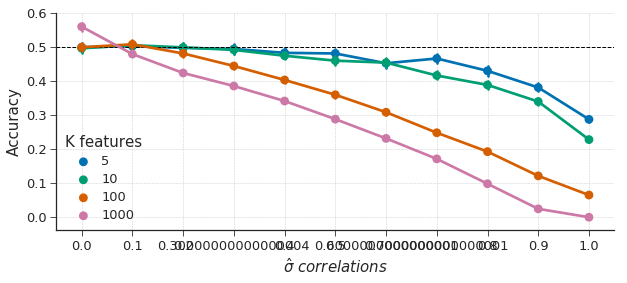

In [69]:
results_2_df = pd.DataFrame(results_2)

fig = plt.figure(figsize=(10, 4))
ax = sns.pointplot(data=results_2_df, x='corr_cy', y='acc', hue='k_feat', palette='colorblind')
ax.grid(ls='--', lw=0.5)
ax.legend_.set_title('K features')
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.setp(ax.get_legend().get_title(), fontsize='15')
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$\hat{\sigma}\ correlations$', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_yticklabels(ax.get_yticks().round(2), fontsize=13)
ax.axhline(y=0.5, ls='--', lw=1, c='k')

sns.despine()
fig.show()

Perhaps for a supplementary figure:

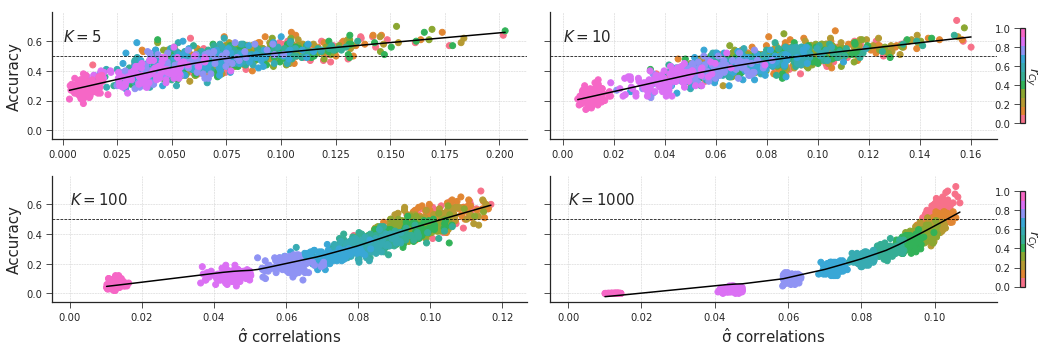

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=False, figsize=(15, 5))
for ax, k in zip(axes.flat, [5, 10, 100, 1000]):
    tmp_df = results_2_df.query('k_feat == @k')
    max_x = tmp_df.std_corr.max() + 0.01
    ax.set_xlim(-.005, max_x)
    spl = ax.scatter(tmp_df.std_corr, tmp_df.acc, c=tmp_df.corr_cy, cmap=my_cmap)
    
    if k in [10, 1000]:
        cb = fig.colorbar(spl, cmap=my_cmap, ax=ax, fraction=0.01)
        cb.set_label('$r_{Cy}$', rotation=270, labelpad=15, fontsize=13)

    ax = sns.regplot(data=tmp_df, x='std_corr', y='acc', ax=ax, lowess=True,
                     scatter=False, color='k', line_kws=dict(lw=1.5))

    ax.grid(ls='--', lw=.5)
    ax.axhline(y=0.5, ls='--', c='k', lw=0.75)
    if k in [10, 1000]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy', fontsize=15)
        
    if k in [100, 1000]:
        ax.set_xlabel('$\mathrm{\hat{\sigma}\ correlations}$', fontsize=15)
    else:
        ax.set_xlabel('')

    ax.text(0.0, 0.6, '$K = %i$' % k, fontsize=15)

fig.tight_layout()
sns.despine()
fig.savefig('figs/stdcorr_accuracy_for_different_K.png', dpi=200)

### Foldwise confound regression solves negative bias
If we regress it out foldwise, everything stays nicely at 50%:

In [79]:
corrs_cy = np.arange(0, 1.1, 0.1)
k_feats = [5, 10, 100, 1000]
n_sims = 20
n_samp = 100
n_folds = 10

results_3 = dict(corr_cy=[], k_feat=[], acc=[], std_corr=[])

for k_feat in k_feats:
    
    results_3['k_feat'].extend([k_feat] * n_sims * len(corrs_cy))
    results_3['corr_cy'].extend(np.repeat(corrs_cy, n_sims))
    
    res = jl.Parallel(n_jobs=6, verbose=0)(jl.delayed(simulate_and_classify_data_with_confound)(n_sims, n_samp, k_feat, n_folds,
                                                                                                 corr_cy, verbose=True, cross_validate=True) for corr_cy in corrs_cy)
    accs, std_corrs = [r[0] for r in res], [r[1] for r in res]
    results_3['acc'].extend([a for this_acc in accs for a in this_acc])
    results_3['std_corr'].extend([s for this_std_corr in std_corrs for s in this_std_corr])

HBox(children=(IntProgress(value=0, description='0.600/5', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/5', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/5', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/5', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/5', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/10', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/10', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/10', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/10', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/10', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/100', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/100', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/100', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/100', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/100', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.600/1000', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.700/1000', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.800/1000', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='0.900/1000', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1.000/1000', max=20), HTML(value='')))

And plot it together with WDCR. Probably supplementary figure as well.

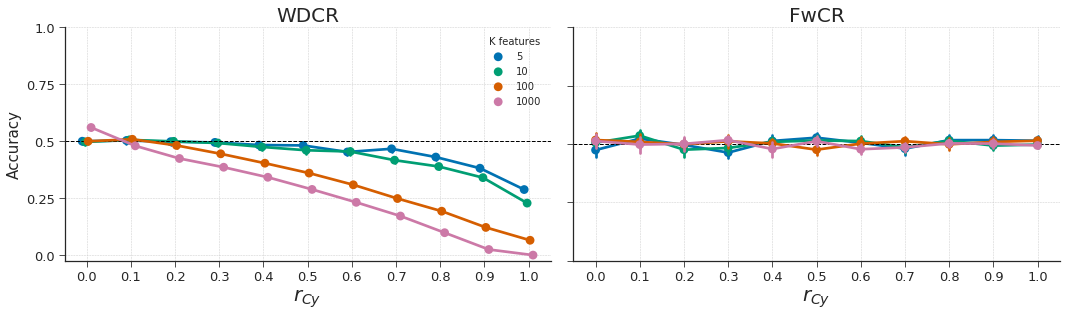

In [82]:
results_3_df = pd.DataFrame(results_3)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 4.5))

ax = axes[0]
ax.set_ylim(-.025, 1)
ax = sns.pointplot(data=pd.DataFrame(results_2), x='corr_cy', y='acc', hue='k_feat', palette='colorblind', ax=ax, dodge=0.2)
ax.grid(ls='--', lw=0.5)
ax.legend_.set_title('K features')
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$\hat{\sigma}\ correlations$', fontsize=15)
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_xticklabels(corrs_cy.round(2), fontsize=13)
ax.set_yticklabels(np.arange(0, 1.1, 0.25).round(2), fontsize=13)
ax.axhline(y=0.5, ls='--', lw=1, c='k')
ax.set_title('WDCR', fontsize=20)
ax.set_xlabel('$r_{Cy}$', fontsize=20)

ax = axes[1]
ax.set_ylim(-.025, 1)
ax = sns.pointplot(data=results_3_df, x='corr_cy', y='acc', hue='k_feat', palette='colorblind', ax=ax)
ax.grid(ls='--', lw=0.5)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$r_{Cy}$', fontsize=20)
ax.set_xticklabels(np.round(corrs_cy, 1), fontsize=13)
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels(np.arange(0, 1.1, 0.25).round(2), fontsize=13)

ax.axhline(y=0.5, ls='--', lw=1, c='k')
ax.set_ylim(0.0, 1)
ax.legend_.remove()
ax.set_ylabel('')
ax.set_yticklabels([], fontsize=13)
ax.set_title('FwCR', fontsize=20)

sns.despine()
fig.tight_layout()
fig.savefig('figs/wdcr_fwcr_null_data.png', dpi=200)

Master figure:

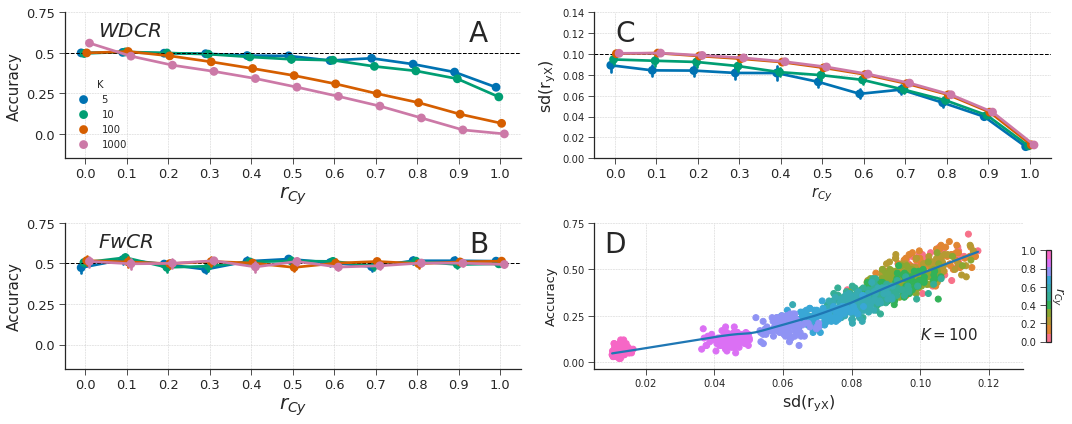

In [159]:
from matplotlib.colors import ListedColormap

#fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(15, 4.5))
fig = plt.figure(figsize=(15, 6))
ax = plt.subplot2grid((2, 2), (0, 0))
ax.set_ylim(-.15, .6)
ax = sns.pointplot(data=results_2_df, x='corr_cy', y='acc', hue='k_feat', palette='colorblind', ax=ax, dodge=0.2)
ax.grid(ls='--', lw=0.5)
ax.legend(loc=3)
ax.legend_.set_title('K')

ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$\hat{\sigma}\ correlations$', fontsize=15)
ax.set_yticks(np.arange(0, 0.76, 0.25))
ax.set_xticklabels(corrs_cy.round(2), fontsize=13)
ax.set_yticklabels(np.arange(0, 0.76, 0.25).round(2), fontsize=13)
ax.axhline(y=0.5, ls='--', lw=1, c='k')
ax.set_xlabel('$r_{Cy}$', fontsize=20)
ax.text(9.25, 0.57, 'A', fontsize=28)
ax.text(0.3, 0.6, '$WDCR$', fontsize=20)

ax = plt.subplot2grid((2, 2), (1, 0))
ax.set_ylim(-.15, .75)
ax = sns.pointplot(data=results_3_df, x='corr_cy', y='acc', hue='k_feat', palette='colorblind', ax=ax, dodge=0.2)
ax.grid(ls='--', lw=0.5)
#ax.legend(loc=3)
#ax.legend_.set_title('K features')
ax.legend_.remove()
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$\hat{\sigma}\ correlations$', fontsize=15)
ax.set_yticks(np.arange(0, 0.76, 0.25))
ax.set_xticklabels(corrs_cy.round(2), fontsize=13)
ax.set_yticklabels(np.arange(0, 0.76, 0.25).round(2), fontsize=13)
ax.axhline(y=0.5, ls='--', lw=1, c='k')
ax.set_xlabel('$r_{Cy}$', fontsize=20)
ax.text(9.25, 0.57, 'B', fontsize=28)
ax.text(0.3, 0.6, '$FwCR$', fontsize=20)

ax = plt.subplot2grid((2, 2), (0, 1))
ax.set_ylim(0, 0.140)
ax = sns.pointplot(data=results_2_df, x='corr_cy', y='std_corr', hue='k_feat', palette='colorblind', ax=ax, dodge=0.2)
ax.grid(ls='--', lw=0.5)
ax.set_ylabel('$\mathrm{sd(r_{yX})}$', fontsize=16)
ax.set_xlabel('$r_{Cy}$', fontsize=15)
ax.set_xticklabels(np.round(corrs_cy, 1), fontsize=13)
ax.legend_.remove()
ax.axhline(y=std_rho_0, c='k', ls='--', lw=1)
ax.text(0, 0.1125, 'C', fontsize=28)

ax = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
ax.set_xlim(0.005, 0.130)
tmp_df = results_2_df.query('k_feat == 100')
cpalette = sns.color_palette("husl", n_colors=len(corrs_cy))
my_cmap = ListedColormap(cpalette.as_hex())
spl = ax.scatter(tmp_df.std_corr, tmp_df.acc, c=tmp_df.corr_cy, cmap=my_cmap)
cb = fig.colorbar(spl, cmap=my_cmap, ax=plt.gca(), fraction=0.01)
cb.set_label('$r_{Cy}$', rotation=270, labelpad=15, fontsize=13)

ax = sns.regplot(data=tmp_df, x='std_corr', y='acc', ax=ax, lowess=True,
                 scatter=False)
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_xlabel('$\mathrm{sd(r_{yX})}$', fontsize=16)
ax.grid(lw=0.5, ls='--')
ax.set_yticks(np.arange(0, 0.751, 0.25))
ax.text(0.10, 0.125, '$K = 100$', fontsize=15)
ax.text(0.008, 0.59, 'D', fontsize=28)

sns.despine()
fig.tight_layout()
fig.savefig('figs/wdcr_effect_null_data.png', dpi=200)